# ROI detection with Deep Learning
Notebook used to test ROI detection using PyTorch

In [1]:
% matplotlib inline

import os, sys, time, shutil
import random

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch.utils import data

from utils_common.image import imread_to_float
from utils_common.metrics import dice_coef, crop_dice_coef
from utils_data import normalize_range, get_all_dataloaders, get_filenames
from utils_model import weights_initialization, CustomUNet
from utils_train import train
from utils_test import predict, evaluate, show_sample

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


## Parameters
Hyperparameters, folder names, etc.

In [2]:
n_epochs = 10
batch_size = 32
learning_rate = 0.001
diceC_scale = 4.0 # scale of the cropping (w.r.t. ROI's bounding box) for the dice coef.

input_channels = "R" # Channel to use as input
u_depth = 4
out1_channels = 16

model_name = "test"
model_dir = "models/"
data_dir = "../dataset/"

## Data loading
Create dataloaders, and build data-related constants.

In [3]:
# Create dataloaders
dataloaders = get_all_dataloaders(
    data_dir,
    batch_size, 
    input_channels = input_channels,
    test_dataloader = True,
    train_transform = None, train_target_transform = None,
    eval_transform = None, eval_target_transform = None
)

N_TRAIN = len(dataloaders["train"].dataset)
N_VALID = len(dataloaders["valid"].dataset)
N_TEST = len(dataloaders["test"].dataset)
HEIGHT, WIDTH = io.imread(get_filenames(os.path.join(data_dir, "train/"))[0][0]).shape[:2]
print("%d images of size %dx%d." % (N_TRAIN + N_VALID + N_TEST, HEIGHT, WIDTH))
print("%d to train" % N_TRAIN)
print("%d to validation" % N_VALID)
print("%d to test" % N_TEST)

# Compute class weights (as pixel imbalance)
pos_count = 0
neg_count = 0
# for y_name in y_filenames:
#     y = io.imread(y_name)
#     pos_count += (y == 255).sum()
#     neg_count += (y == 0).sum()
# for _, batch_y in dataloaders["train"]:
#     pos_count += (y == 1).sum().item()
#     neg_count += (y == 0).sum().item()
# pos_weight = torch.tensor(neg_count / pos_count).to(device)
# Following has been pre-computed
pos_weight = torch.tensor(120.946829).to(device)
if pos_count != 0 and neg_count != 0:
    print("{} ROI pixels, and {} background --> {:f} positive weighting.".format(
        pos_count, neg_count, pos_weight.item()))
else:
    print("{:.3f} positive weighting.".format(pos_weight.item()))

79150 images of size 192x256.
48150 to train
14100 to validation
16900 to test
120.947 positive weighting.


## Model definition
Define model, loss, and optimizer.

In [4]:
model = CustomUNet(len(input_channels), u_depth=u_depth, 
                   out1_channels=out1_channels, batchnorm=True, device=device)
print(model)

# Save the "architecture" of the model by copy/pasting the class definition file
os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)
shutil.copy("utils_model.py", os.path.join(model_dir, model_name, "utils_model_save.py"))

loss_fn = torch.nn.BCEWithLogitsLoss(reduction='elementwise_mean', pos_weight=pos_weight)

dice_metric = lambda preds, targets: torch.tensor(
    dice_coef((torch.sigmoid(preds.cpu()) > 0.5).detach().numpy(),
              targets.cpu().detach().numpy()))

diceC_metric = lambda preds, targets: torch.tensor(
    crop_dice_coef((torch.sigmoid(preds.cpu()) > 0.5).detach().numpy(),
                   targets.cpu().detach().numpy(),
                   scale = diceC_scale))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CustomUNet(
  (activation): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UNetConv(
      (activation): ReLU()
      (co

## Training

In [5]:
best_model, history = train(model,
                            dataloaders,
                            loss_fn,
                            optimizer,
                            n_epochs,
                            metrics = {"dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric},
                            criterion_metric = "dice",
                            model_dir = os.path.join(model_dir, model_name),
                            replace_dir = True,
                            verbose = 1)

Epoch 1/10  (Elapsed time: 0h 00min 00s)
----------------------------------------
Batch (over 1505): 1...150...300...450...600...750...900...1050...1200...1350...1500...
Train loss: 0.260407 - dice: 0.330170 - diC4.0: 0.470861
Valid loss: 0.120355 - dice: 0.382830 - diC4.0: 0.526852

Epoch 2/10  (Elapsed time: 0h 02min 53s)
----------------------------------------
Batch (over 1505): 1...150...300...450...600...750...900...1050...1200...1350...1500...
Train loss: 0.105402 - dice: 0.414507 - diC4.0: 0.543339
Valid loss: 0.106339 - dice: 0.412911 - diC4.0: 0.548645

Epoch 3/10  (Elapsed time: 0h 05min 45s)
----------------------------------------
Batch (over 1505): 1...150...300...450...600...750...900...1050...1200...1350...1500...
Train loss: 0.098733 - dice: 0.425527 - diC4.0: 0.550303
Valid loss: 0.102691 - dice: 0.441404 - diC4.0: 0.570654

Epoch 4/10  (Elapsed time: 0h 08min 35s)
----------------------------------------
Batch (over 1505): 1...150...300...450...600...750...900...1050

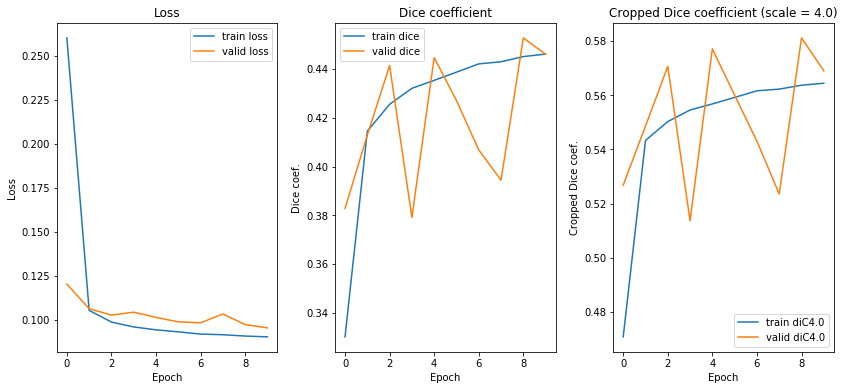

In [6]:
fig = plt.figure(figsize=(12,6))
plt.subplot(131)
plt.title("Loss")
plt.plot(history["epoch"], history["loss"])
plt.plot(history["epoch"], history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train loss", "valid loss"])
plt.subplot(132)
plt.title("Dice coefficient")
plt.plot(history["epoch"], history["dice"])
plt.plot(history["epoch"], history["val_dice"])
plt.xlabel("Epoch")
plt.ylabel("Dice coef.")
plt.legend(["train dice", "valid dice"])
plt.subplot(133)
plt.title("Cropped Dice coefficient (scale = %.1f)" % diceC_scale)
plt.plot(history["epoch"], history["diC%.1f"%diceC_scale])
plt.plot(history["epoch"], history["val_diC%.1f"%diceC_scale])
plt.xlabel("Epoch")
plt.ylabel("Cropped Dice coef.")
plt.legend(["train diC%.1f"%diceC_scale, "valid diC%.1f"%diceC_scale])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Testing
Test and visualize best model on test data. Note that this is for debugging purposes: you should use the test data only at the very end!

Image   2327: dice = 0.686109 - diC4.0 = 0.645653 - 
Image  10539: dice = 0.611785 - diC4.0 = 0.583707 - 
Image  11426: dice = 0.595570 - diC4.0 = 0.584752 - 
Image   3722: dice = 0.614173 - diC4.0 = 0.623161 - 


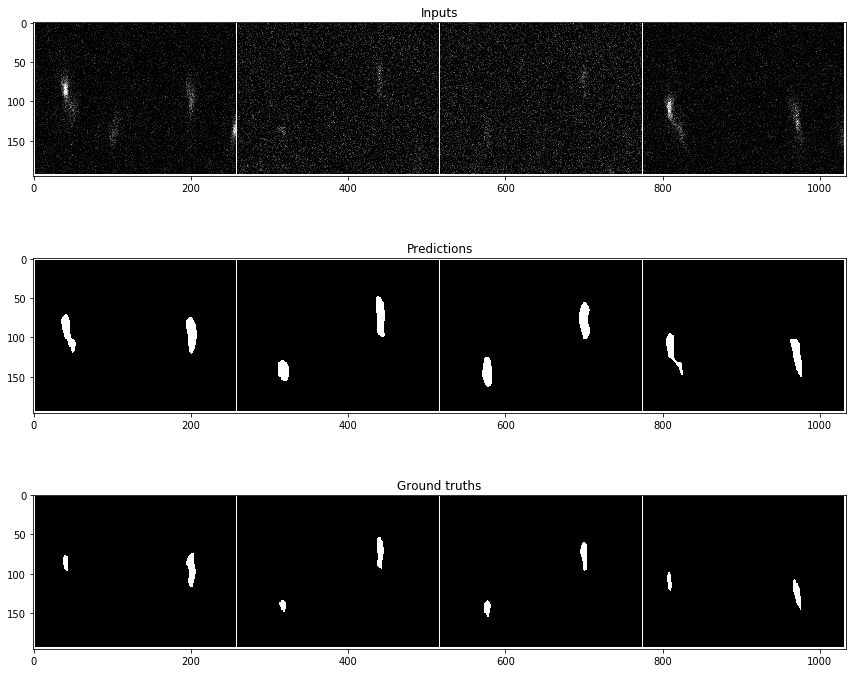

In [6]:
show_sample(best_model, dataloaders["valid"], n_samples=4, 
            post_processing = lambda preds: torch.tensor(torch.sigmoid(preds) > 0.5, dtype=torch.float32), 
            metrics = ({"dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric}))

Image  13488: dice = 0.783147 - diC4.0 = 0.764487 - 
Image    890: dice = 0.820253 - diC4.0 = 0.820440 - 
Image  12793: dice = 0.608209 - diC4.0 = 0.613060 - 
Image   9596: dice = 0.762808 - diC4.0 = 0.773736 - 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


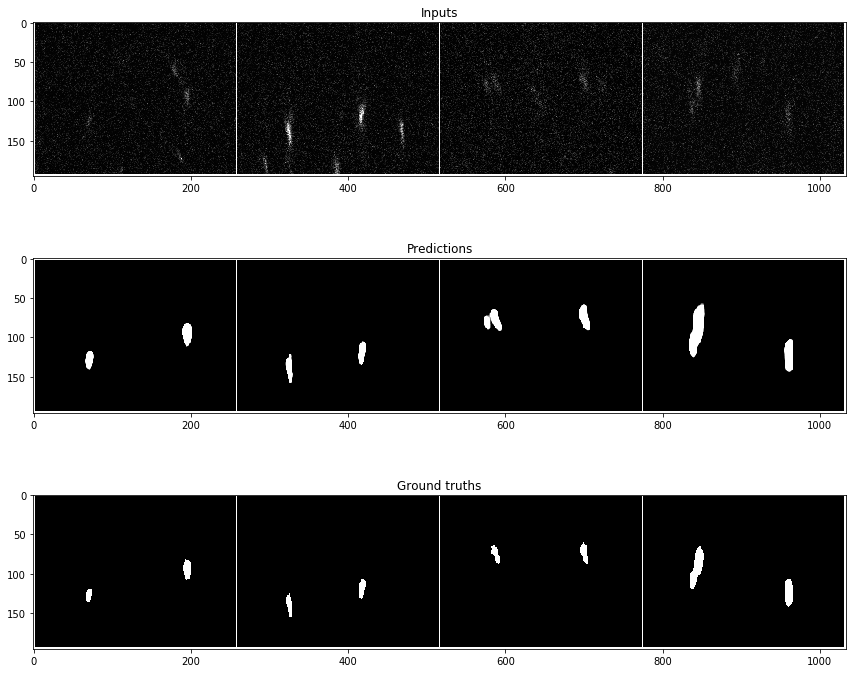

In [7]:
show_sample(best_model, dataloaders["valid"], n_samples=4, 
            post_processing = None, 
            metrics = ({"dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric}))